## Predicting CrossFit Games Ranking based on Benchmark Workout Performance

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import datatable as dt
import xlrd
from ydata_profiling import ProfileReport
from bs4 import BeautifulSoup
import json
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

In [2]:
df = pd.read_csv('data/processed/data_processed.csv')
df = df.drop(columns={'Year'})
df

,Athlete,Affiliate,Country,Region,Division,Rank,Games_Level,Qualifier,Back Squat (lbs),Clean and Jerk (lbs),Deadlift (lbs),Snatch (lbs),Fight Gone Bad,Max Pull-ups,Chad1000x (s),L1 Benchmark (s),Filthy 50 (s),Fran (s),Grace (s),Helen (s),Run 5k (s),Sprint 400m (s)
0,Yagiz Diyaroglu,NaN,NaN,Africa,Boys (14-15),NaN,NaN,NaN,187.3927,NaN,242.50820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jandré Erasmus,NaN,NaN,Africa,Boys (16-17),NaN,NaN,NaN,265.0000,174.00000,342.00000,NaN,NaN,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Roan van Heerden,CrossFit 10 Star,NaN,Africa,Men,NaN,NaN,NaN,220.4620,176.36960,264.55440,132.27720,291.0,1.0,NaN,NaN,NaN,540.0,NaN,NaN,2400.0,120.0
3,David Swarts,Cape CrossFit,NaN,Africa,Men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Colin Pinkham,NaN,NaN,Africa,Men,NaN,NaN,NaN,264.5544,163.14188,365.96692,103.61714,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1731.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85326,Troels Kjær Aaskilde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1196.0,NaN
85327,Wafik Abed El Malak,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1220.0,NaN
85328,Will Marshall,CrossFit Athletics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.00000,NaN,NaN,NaN,NaN,NaN,252.0,NaN,NaN,NaN,NaN
85329,Wouter Vanloffelt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1185.0,64.0


In [3]:
benchmark_workouts = ['Back Squat (lbs)', 'Clean and Jerk (lbs)', 
                      'Deadlift (lbs)', 'Snatch (lbs)', 
                      'Fight Gone Bad', 'Max Pull-ups', 
                      'Chad1000x (s)', 'L1 Benchmark (s)', 
                      'Filthy 50 (s)', 'Fran (s)', 'Grace (s)', 
                      'Helen (s)', 'Run 5k (s)', 'Sprint 400m (s)']

time_based_workouts = ['Chad1000x (s)', 'L1 Benchmark (s)', 
                      'Filthy 50 (s)', 'Fran (s)', 'Grace (s)', 
                      'Helen (s)', 'Run 5k (s)', 'Sprint 400m (s)']

In [4]:
def seconds_to_hours_minutes_seconds(df, index, column):
    value = df.loc[index, column]
    
    if pd.isna(value):  
        return np.nan

    hours, remainder = divmod(value, 3600)
    minutes, seconds = divmod(remainder, 60)

    df.loc[index, column] = f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"
            
def ydata_profile(df, title, seconds_format):
    df.profile_report(missing_diagrams={"Heatmap": False})
    profile = ProfileReport(df, title=title)
    profile.to_file(f"data/processed/{title}.html")
    
    json_data = profile.to_json()
    profile.to_file(f"data/processed/{title}.json")
    with open(f"data/processed/{title}.json", 'r') as file:
        data = json.load(file)
        
    relevant_variables = ['p_missing', 'mean', 'std', 'min', 'max', '5%', '25%', '50%', '75%', '95%', 'iqr']

    statistics = {}

    for workout in benchmark_workouts:
        statistics[workout] = {}
        if workout in data['variables']:
            for variable in relevant_variables:
                if variable in data['variables'][workout]:
                    statistics[workout][variable] = data['variables'][workout][variable]
                else:
                    statistics[workout][variable] = None
        else:
            statistics[workout] = {variable: None for variable in relevant_variables}


    statistics = pd.DataFrame.from_dict(statistics, orient='index')
    statistics['p_missing'] = statistics['p_missing'] * 100
 
    if not seconds_format:
        for index in time_based_workouts:
            for column in ['mean', 'std', 'min', 'max','5%', '25%', '50%', '75%', '95%', 'iqr']:
                seconds_to_hours_minutes_seconds(statistics, index, column)
        statistics.index = statistics.index.str.replace(' (s)', "")
    else: pass
    
#     html_table = statistics.to_html()
#     print(html_table)
    
    return statistics 

In [5]:
df['Qualifier'].unique()

array([nan, 'quarterfinals', 'open', 'semifinals', 'games'], dtype=object)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,p_missing,mean,std,min,max,5%,25%,50%,75%,95%,iqr
Back Squat (lbs),6.674877,361.258148,65.803172,4.0,709.88764,253.5313,319.6699,363.7623,405.00000,462.9702,85.33010
Clean and Jerk (lbs),7.315271,266.882558,46.489269,10.0,425.00000,187.3927,237.0000,265.0000,299.82832,340.0000,62.82832
Deadlift (lbs),6.502463,436.327622,69.322790,6.0,981.05590,325.0000,396.8316,440.9240,485.00000,545.0000,88.16840
Snatch (lbs),8.990148,208.768097,40.869739,1.0,489.42564,143.3003,185.0000,209.4389,235.00000,275.0000,50.00000
Fight Gone Bad,78.325123,337.345455,63.627587,42.0,581.00000,233.9500,300.0000,336.0000,376.00000,443.1500,76.00000
Max Pull-ups,55.911330,39.947486,24.382446,1.0,614.00000,14.0000,27.0000,40.0000,50.00000,68.0000,23.00000
Chad1000x (s),98.793103,3856.122449,693.961203,2744.0,5520.00000,2906.6000,3380.0000,3671.0000,4307.00000,5147.4000,927.00000
L1 Benchmark (s),99.655172,276.571429,68.161250,179.0,384.00000,179.6500,222.0000,285.5000,318.75000,383.3500,96.75000
Filthy 50 (s),86.773399,1455.413408,353.907195,603.0,3504.00000,986.4000,1196.0000,1410.0000,1650.00000,2091.2000,454.00000
Fran (s),39.261084,223.443633,98.087941,97.0,1342.00000,130.0000,158.0000,195.0000,262.75000,407.0000,104.75000


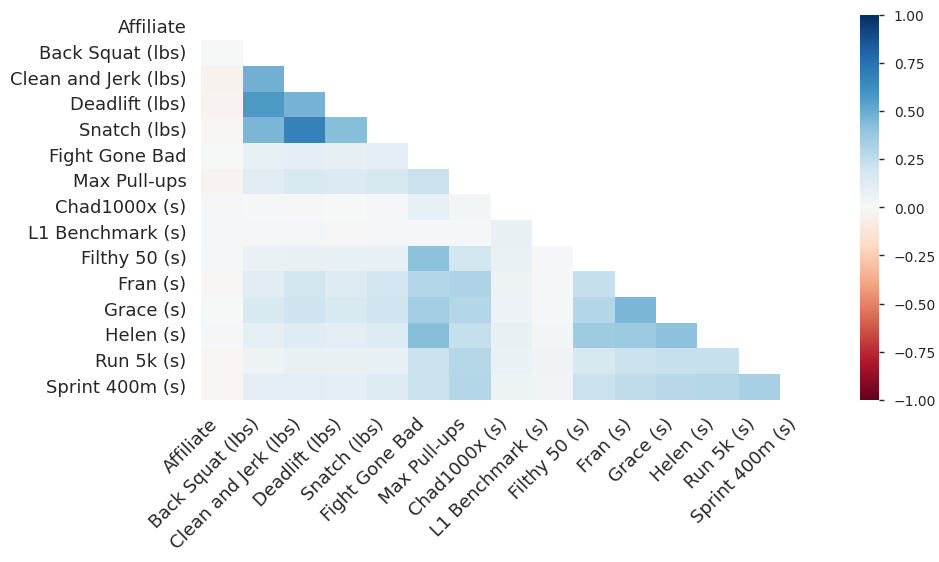

In [6]:
df_copy = df[(df['Division']=="Men") & (df['Qualifier']=="open")].copy()
stats_men_open = ydata_profile(df_copy, "men_open", True)
stats_men_open

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,p_missing,mean,std,min,max,5%,25%,50%,75%,95%,iqr
Back Squat (lbs),5.901427,397.033044,53.951495,22.04620,551.1550,315.0000,365.00,396.8316,430.00000,485.0082,65.00000
Clean and Jerk (lbs),5.123217,298.732817,37.046362,26.45544,418.8778,242.5082,275.00,300.0000,321.43726,355.0000,46.43726
Deadlift (lbs),6.744488,467.414369,60.296259,28.00000,740.0000,385.0000,435.00,465.0000,505.00000,555.0000,70.00000
Snatch (lbs),5.512322,235.491914,31.938009,1.00000,315.0000,185.0000,215.00,235.0000,255.73592,285.0000,40.73592
Fight Gone Bad,76.783398,368.824022,64.363592,38.00000,588.0000,275.7000,330.00,367.5000,409.00000,474.3000,79.00000
Max Pull-ups,50.064851,49.797403,20.586030,1.00000,420.0000,23.0000,40.00,50.0000,60.00000,75.0000,20.00000
Chad1000x (s),98.508431,3708.130435,693.382572,2068.00000,4855.0000,2645.7000,3416.50,3712.0000,4150.00000,4750.3000,733.50000
L1 Benchmark (s),99.675746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Filthy 50 (s),85.927367,1301.654378,224.932347,890.00000,2325.0000,995.2000,1140.00,1282.0000,1439.00000,1717.4000,299.00000
Fran (s),28.858625,172.651778,88.756500,97.00000,2260.0000,125.0000,140.00,159.0000,181.00000,250.2000,41.00000


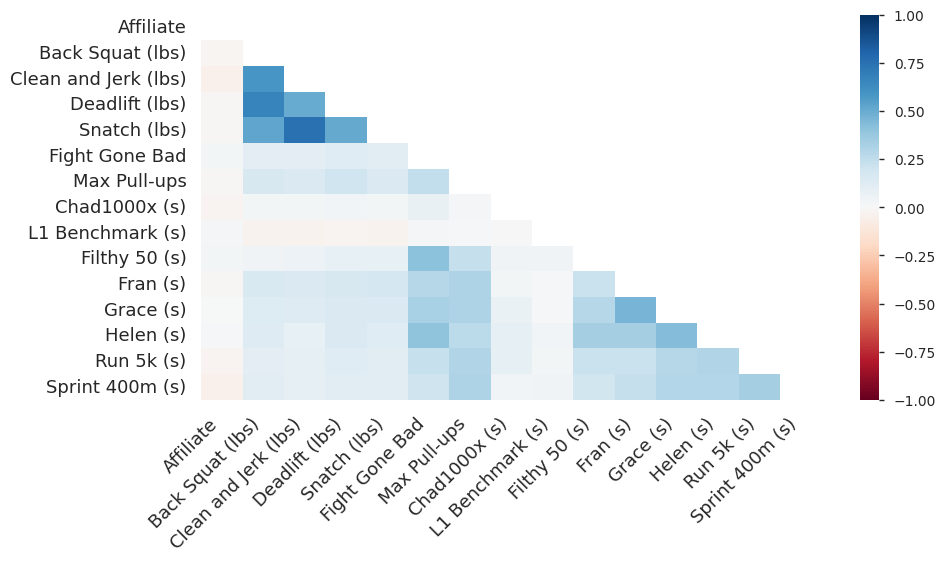

In [7]:
df_copy = df[(df['Division']=="Men") & (df['Qualifier']=="quarterfinals")].copy()
stats_men_qf = ydata_profile(df_copy, "men_quarterfinals", True)
stats_men_qf

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,p_missing,mean,std,min,max,5%,25%,50%,75%,95%,iqr
Back Squat (lbs),6.593407,432.242478,45.995630,264.5544,600.0,374.828320,405.00000,430.00000,455.00000,500.00000,50.00000
Clean and Jerk (lbs),6.593407,331.268539,37.458153,160.0000,410.0,277.462000,315.00000,335.00000,350.00000,392.46528,35.00000
Deadlift (lbs),8.791209,514.799707,52.233348,308.6468,650.0,445.000000,485.01640,509.26722,537.50000,604.50000,52.48360
Snatch (lbs),6.593407,265.939639,27.470928,154.3234,342.0,223.133296,255.73592,265.00000,279.98674,301.60000,24.25082
Fight Gone Bad,79.120879,412.052632,58.772134,309.0000,483.0,313.500000,374.00000,418.00000,470.50000,482.10000,96.50000
Max Pull-ups,49.450549,62.086957,14.249875,32.0000,90.0,42.000000,50.00000,60.50000,74.00000,82.75000,24.00000
Chad1000x (s),100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L1 Benchmark (s),100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Filthy 50 (s),91.208791,1251.125000,329.098091,922.0000,1952.0,964.700000,1048.50000,1171.50000,1275.50000,1792.40000,227.00000
Fran (s),28.571429,141.353846,22.659456,110.0000,252.0,118.400000,126.00000,134.00000,149.00000,179.20000,23.00000


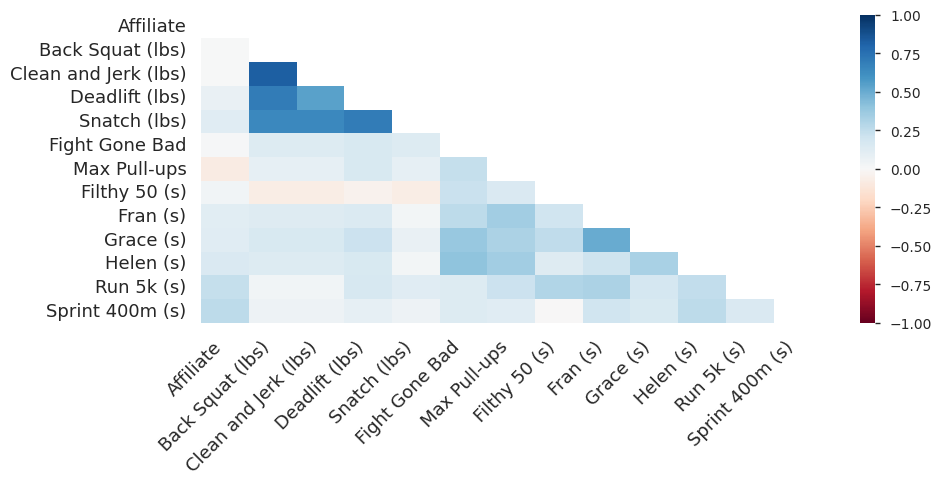

In [8]:
df_copy = df[(df['Division']=="Men") & (df['Qualifier']=="semifinals")].copy()
stats_men_sf = ydata_profile(df_copy, "men_semifinals", True)
stats_men_sf

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,p_missing,mean,std,min,max,5%,25%,50%,75%,95%,iqr
Back Squat (lbs),5.555556,466.840591,25.437804,435.00000,545.00000,439.739200,455.00,460.0,475.0000,505.000000,20.0000
Clean and Jerk (lbs),5.555556,359.500860,14.989064,335.00000,380.00000,339.000000,345.00,360.0,374.7854,377.600000,29.7854
Deadlift (lbs),5.555556,554.057826,40.567272,489.42564,635.00000,501.885128,530.00,540.0,573.2012,619.000000,43.2012
Snatch (lbs),0.000000,291.792069,12.380970,275.00000,313.05604,275.000000,281.25,290.0,300.0000,310.458406,18.7500
Fight Gone Bad,66.666667,470.000000,56.596820,389.00000,522.00000,397.000000,430.00,484.0,517.7500,521.500000,87.7500
Max Pull-ups,38.888889,69.181818,8.316468,54.00000,85.00000,57.000000,64.50,72.0,73.0000,80.000000,8.5000
Chad1000x (s),100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L1 Benchmark (s),100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Filthy 50 (s),66.666667,1002.833333,161.420465,795.00000,1216.00000,819.750000,899.75,983.5,1121.2500,1198.250000,221.5000
Fran (s),27.777778,130.076923,14.863050,109.00000,171.00000,115.600000,123.00,125.0,134.0000,154.200000,11.0000


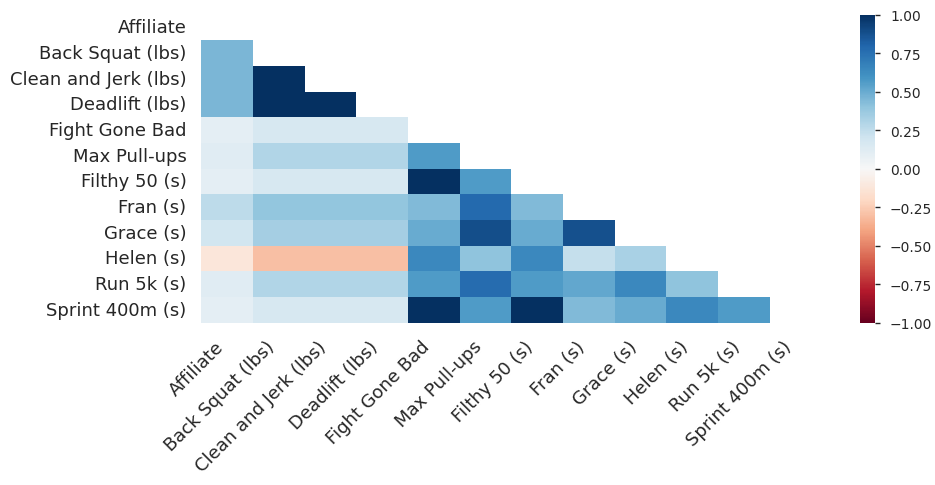

In [9]:
df_copy = df[(df['Division']=="Men") & (df['Qualifier']=="games")].copy()
stats_men_g = ydata_profile(df_copy, "men_games", True)
stats_men_g

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,p_missing,mean,std,min,max,5%,25%,50%,75%,95%,iqr
Back Squat (lbs),7.720207,230.525783,45.339704,80.00000,410.0000,160.00,200.00,229.28048,260.00000,308.0000,60.00000
Clean and Jerk (lbs),8.134715,168.918635,32.270369,65.00000,297.6237,120.00,145.00,165.34650,190.00000,225.0000,45.00000
Deadlift (lbs),6.787565,279.035703,49.359578,8.81848,440.9240,205.00,245.00,275.57750,310.92571,360.0000,65.92571
Snatch (lbs),10.569948,129.441839,28.267916,40.00000,231.4851,85.00,110.00,130.00000,147.70954,176.8424,37.70954
Fight Gone Bad,79.792746,292.338462,62.705115,136.00000,730.0000,195.35,255.25,289.00000,326.00000,394.0000,70.75000
Max Pull-ups,68.860104,22.459235,13.734461,1.00000,100.0000,4.00,12.00,21.00000,30.00000,48.0000,18.00000
Chad1000x (s),98.756477,3948.791667,749.163823,2573.00000,6096.0000,3072.25,3414.00,3883.00000,4388.25000,4778.4000,974.25000
L1 Benchmark (s),99.844560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Filthy 50 (s),88.082902,1598.130435,341.535398,720.00000,3048.0000,1120.95,1342.25,1562.00000,1799.50000,2130.7500,457.25000
Fran (s),57.098446,298.182367,116.072807,114.00000,858.0000,149.00,210.75,280.00000,360.00000,513.6000,149.25000


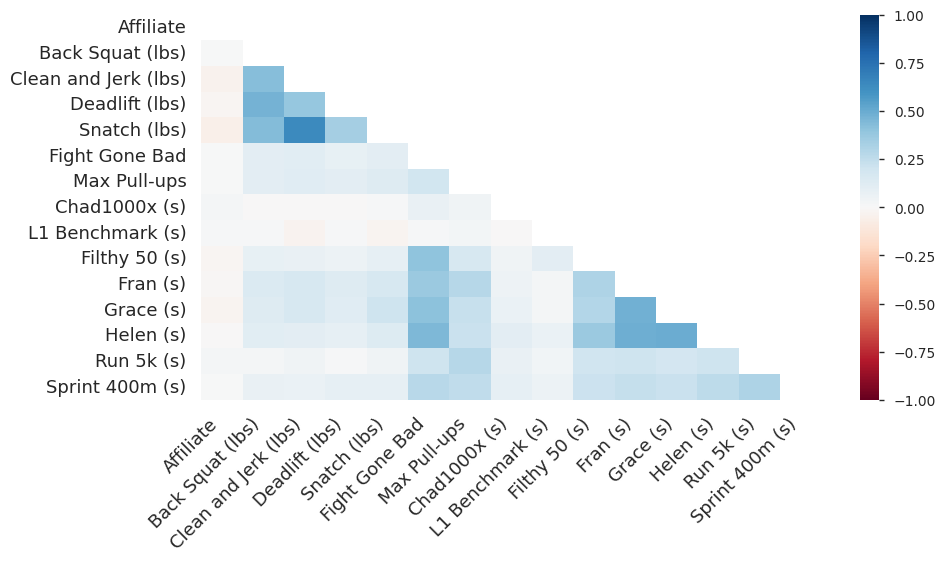

In [10]:
df_copy = df[(df['Division']=="Women") & (df['Qualifier']=="open")].copy()
stats_women_open = ydata_profile(df_copy, "women_open", True)
stats_women_open

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,p_missing,mean,std,min,max,5%,25%,50%,75%,95%,iqr
Back Squat (lbs),7.795699,259.287821,36.938617,90.00000,365.00000,205.00,235.00000,260.00000,285.00000,320.000000,50.00000
Clean and Jerk (lbs),7.930108,195.870149,28.416826,75.00000,509.26722,155.00,180.00000,195.00000,215.00000,235.715472,35.00000
Deadlift (lbs),8.467742,309.612506,39.214127,198.41580,495.00000,245.00,285.00000,306.44218,332.89762,375.000000,47.89762
Snatch (lbs),8.736559,151.531957,23.559229,2.20462,215.00000,115.00,135.84322,150.00000,165.34650,190.000000,29.50328
Fight Gone Bad,78.763441,328.259494,46.075703,185.00000,440.00000,237.70,305.25000,327.50000,352.00000,411.150000,46.75000
Max Pull-ups,64.112903,31.895131,13.704873,6.00000,85.00000,12.00,22.00000,30.00000,40.00000,55.000000,18.00000
Chad1000x (s),98.790323,4057.000000,562.052266,3255.00000,5206.00000,3392.20,3730.00000,4030.00000,4094.00000,4943.200000,364.00000
L1 Benchmark (s),99.865591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Filthy 50 (s),86.290323,1467.647059,265.020928,935.00000,2327.00000,1088.55,1288.50000,1433.00000,1640.75000,1846.350000,352.25000
Fran (s),44.354839,224.724638,84.136299,113.00000,846.00000,133.65,170.00000,209.00000,259.25000,359.000000,89.25000


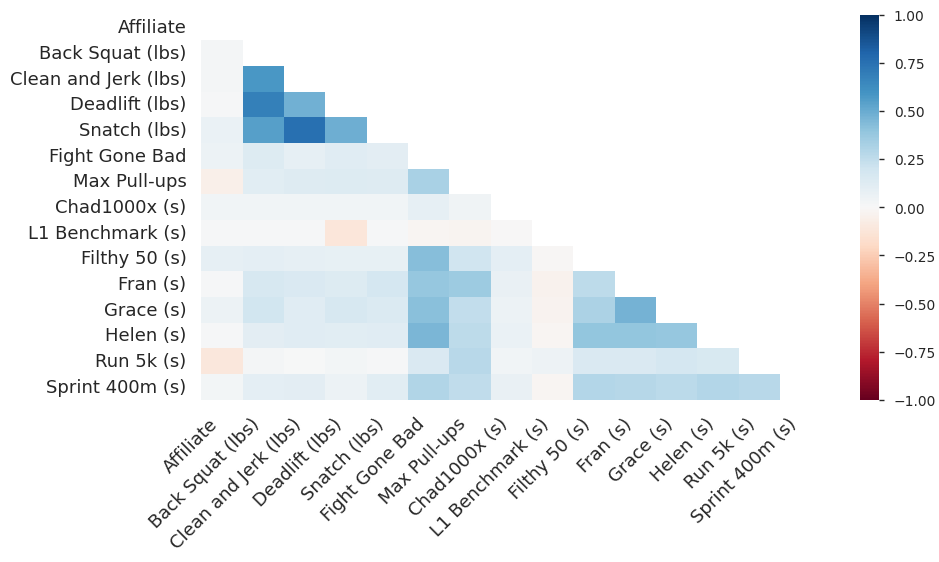

In [11]:
df_copy = df[(df['Division']=="Women") & (df['Qualifier']=="quarterfinals")].copy()
stats_women_qf = ydata_profile(df_copy, "women_quarterfinals", True)
stats_women_qf

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,p_missing,mean,std,min,max,5%,25%,50%,75%,95%,iqr
Back Squat (lbs),10.000000,290.629060,32.906559,220.0,365.000,238.130330,266.25000,296.31185,313.750000,338.500000,47.500000
Clean and Jerk (lbs),5.000000,224.135123,23.143767,165.0,269.000,179.896992,210.00000,230.00000,238.098960,255.000000,28.098960
Deadlift (lbs),8.333333,342.845700,41.845737,220.0,440.924,286.600600,317.83495,341.71610,360.881150,405.856410,43.046200
Snatch (lbs),6.666667,178.622041,23.177927,63.0,215.000,144.575075,170.00000,182.98346,192.351455,202.215315,22.351455
Fight Gone Bad,86.666667,394.000000,43.008305,346.0,464.000,346.700000,369.75000,388.00000,405.250000,459.450000,35.500000
Max Pull-ups,66.666667,49.600000,13.311649,30.0,86.000,30.000000,39.75000,50.00000,60.000000,62.250000,20.250000
Chad1000x (s),98.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L1 Benchmark (s),100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Filthy 50 (s),90.000000,1233.000000,159.556886,1054.0,1410.000,1061.250000,1096.25000,1235.50000,1368.750000,1402.500000,272.500000
Fran (s),41.666667,161.314286,44.882704,118.0,320.000,119.000000,137.00000,149.00000,171.500000,260.100000,34.500000


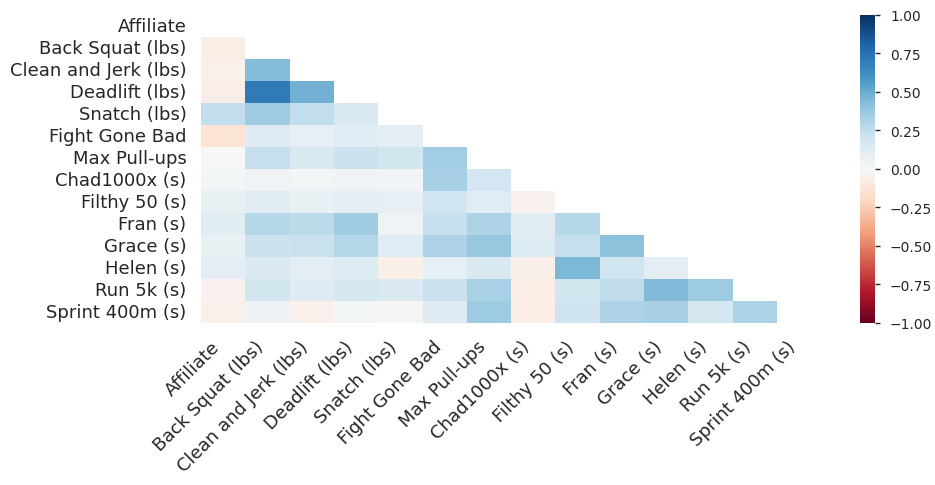

In [12]:
df_copy = df[(df['Division']=="Women") & (df['Qualifier']=="semifinals")].copy()
stats_women_sf = ydata_profile(df_copy, "women_semifinals", True)
stats_women_sf

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,p_missing,mean,std,min,max,5%,25%,50%,75%,95%,iqr
Back Squat (lbs),15.789474,305.315575,25.212427,265.0,350.0000,272.933125,290.144375,300.0000,321.250000,346.25000,31.105625
Clean and Jerk (lbs),0.000000,239.322724,12.092503,220.0,264.5544,220.000000,231.485100,240.0000,245.000000,257.75544,13.514900
Deadlift (lbs),15.789474,368.495438,27.898983,315.0,422.0000,322.500000,352.500000,369.8927,385.202125,409.25000,32.702125
Snatch (lbs),0.000000,194.853385,11.466650,180.0,225.0000,180.000000,188.495010,192.0000,200.310210,211.50000,11.815200
Fight Gone Bad,84.210526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max Pull-ups,63.157895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chad1000x (s),100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L1 Benchmark (s),100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Filthy 50 (s),94.736842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fran (s),57.894737,142.000000,20.092643,124.0,185.0000,124.350000,132.500000,136.0000,142.750000,175.20000,10.250000


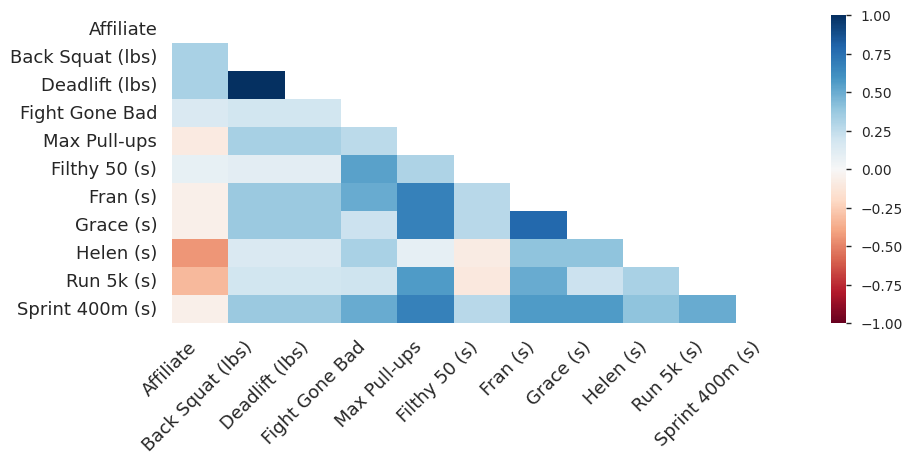

In [13]:
df_copy = df[(df['Division']=="Women") & (df['Qualifier']=="games")].copy()
stats_women_g = ydata_profile(df_copy, "women_games", True)
stats_women_g

In [14]:
stats_dfs = {
    'Men\'s Open': stats_men_open,
    'Men\'s Quarterfinals': stats_men_qf,
    'Men\'s Semifinals': stats_men_sf,
    'Men\'s Games': stats_men_g,
    'Women\'s Open': stats_women_open,
    'Women\'s Quarterfinals': stats_women_qf,
    'Women\'s Semifinals': stats_women_sf,
    'Women\'s Games': stats_women_g
}

categories = list(stats_dfs.keys())

mean_df = pd.DataFrame(index=categories, columns=stats_women_g.index)

for category, df in stats_dfs.items():
    mean_df.loc[category] = df['mean'].fillna(np.nan).values

mean_df = mean_df.astype(float)
mean_df

,Back Squat (lbs),Clean and Jerk (lbs),Deadlift (lbs),Snatch (lbs),Fight Gone Bad,Max Pull-ups,Chad1000x (s),L1 Benchmark (s),Filthy 50 (s),Fran (s),Grace (s),Helen (s),Run 5k (s),Sprint 400m (s)
Men's Open,361.258148,266.882558,436.327622,208.768097,337.345455,39.947486,3856.122449,276.571429,1455.413408,223.443633,169.541381,572.685691,1358.196941,70.012500
Men's Quarterfinals,397.033044,298.732817,467.414369,235.491914,368.824022,49.797403,3708.130435,NaN,1301.654378,172.651778,137.815000,516.445378,1269.744147,65.337292
Men's Semifinals,432.242478,331.268539,514.799707,265.939639,412.052632,62.086957,NaN,NaN,1251.125000,141.353846,100.720930,466.473684,1204.194444,59.913043
Men's Games,466.840591,359.500860,554.057826,291.792069,470.000000,69.181818,NaN,NaN,1002.833333,130.076923,81.666667,453.571429,1161.818182,NaN
Women's Open,230.525783,168.918635,279.035703,129.441839,292.338462,22.459235,3948.791667,NaN,1598.130435,298.182367,192.377660,658.359184,1594.913121,88.521595
Women's Quarterfinals,259.287821,195.870149,309.612506,151.531957,328.259494,31.895131,4057.000000,NaN,1467.647059,224.724638,147.438320,596.790476,1479.673820,78.417266
Women's Semifinals,290.629060,224.135123,342.845700,178.622041,394.000000,49.600000,NaN,NaN,1233.000000,161.314286,121.000000,590.300000,1340.466667,71.357143
Women's Games,305.315575,239.322724,368.495438,194.853385,NaN,NaN,NaN,NaN,NaN,142.000000,99.500000,NaN,NaN,73.500000


In [15]:
for index in mean_df.index:
    for column in time_based_workouts:
        value = mean_df.loc[index, column]
        if pd.isna(value):  
            mean_df.loc[index, column] = np.nan
        else:
            seconds_to_hours_minutes_seconds(mean_df, index, column)
        
mean_df

,Back Squat (lbs),Clean and Jerk (lbs),Deadlift (lbs),Snatch (lbs),Fight Gone Bad,Max Pull-ups,Chad1000x (s),L1 Benchmark (s),Filthy 50 (s),Fran (s),Grace (s),Helen (s),Run 5k (s),Sprint 400m (s)
Men's Open,361.258148,266.882558,436.327622,208.768097,337.345455,39.947486,01:04:16,00:04:36,00:24:15,00:03:43,00:02:49,00:09:32,00:22:38,00:01:10
Men's Quarterfinals,397.033044,298.732817,467.414369,235.491914,368.824022,49.797403,01:01:48,NaN,00:21:41,00:02:52,00:02:17,00:08:36,00:21:09,00:01:05
Men's Semifinals,432.242478,331.268539,514.799707,265.939639,412.052632,62.086957,NaN,NaN,00:20:51,00:02:21,00:01:40,00:07:46,00:20:04,00:00:59
Men's Games,466.840591,359.500860,554.057826,291.792069,470.000000,69.181818,NaN,NaN,00:16:42,00:02:10,00:01:21,00:07:33,00:19:21,NaN
Women's Open,230.525783,168.918635,279.035703,129.441839,292.338462,22.459235,01:05:48,NaN,00:26:38,00:04:58,00:03:12,00:10:58,00:26:34,00:01:28
Women's Quarterfinals,259.287821,195.870149,309.612506,151.531957,328.259494,31.895131,01:07:37,NaN,00:24:27,00:03:44,00:02:27,00:09:56,00:24:39,00:01:18
Women's Semifinals,290.629060,224.135123,342.845700,178.622041,394.000000,49.600000,NaN,NaN,00:20:33,00:02:41,00:02:01,00:09:50,00:22:20,00:01:11
Women's Games,305.315575,239.322724,368.495438,194.853385,NaN,NaN,NaN,NaN,NaN,00:02:22,00:01:39,NaN,NaN,00:01:13
